<a href="https://colab.research.google.com/github/leobioinf0/Registre_de_logs/blob/main/S05_T01_Transformacio_Registre_Log_amb_Regular_expressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nivell 1
L'analista ha d'assegurar-se que els registres consisteixen en una gamma completa de missatges i s'interpreten segons el context. Els elements de registre han d'estandaritzar-se, utilitzant els mateixos termes o terminologia, per evitar confusions i proporcionar cohesió.

Com Científic de Dades se t'ha proporcionat accés als registres-Logs on queda registrada l'activitat de totes les visites a realitzades a la pàgina web de l'agència de viatges "akumenius.com".










## Exercici 1
Estandaritza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".


In [3]:
import re
import pandas as pd

# We use regex to define the separators and capture the different attributes

data = pd.read_csv(
    'https://raw.githubusercontent.com/leobioinf0/Registre_de_logs/main/SMALL_Web_access_log-akumenius.com.txt',
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
    engine='python',
    na_values="-",
    header=None,
    usecols=[0, 1, 4, 5, 6, 7, 8, 9],
    names=['host','ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
    converters={'size': int})

data.head()

,host,ip,time,request,status,size,referer,user_agent
0,localhost,127.0.0.1,[23/Feb/2014:03:10:31 +0100],"""OPTIONS * HTTP/1.0""",200,NaN,"""-""","""Apache (internal dummy connection)"""
1,localhost,127.0.0.1,[23/Feb/2014:03:10:31 +0100],"""OPTIONS * HTTP/1.0""",200,NaN,"""-""","""Apache (internal dummy connection)"""
2,localhost,127.0.0.1,[23/Feb/2014:03:10:31 +0100],"""OPTIONS * HTTP/1.0""",200,NaN,"""-""","""Apache (internal dummy connection)"""
3,localhost,127.0.0.1,[23/Feb/2014:03:10:31 +0100],"""OPTIONS * HTTP/1.0""",200,NaN,"""-""","""Apache (internal dummy connection)"""
4,localhost,127.0.0.1,[23/Feb/2014:03:10:31 +0100],"""OPTIONS * HTTP/1.0""",200,NaN,"""-""","""Apache (internal dummy connection)"""


# Nivell 2

## Exercici 2
Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

We will use [user_agents](https://github.com/selwin/python-user-agents) to get the browser, operating system, and device.


In [4]:
pip install user_agents

In [5]:
from datetime import datetime
from user_agents import parse
from http.client import responses
import numpy as np

df = data.copy()

# Replace "w." and "ww." with "www." in the attribute "host" 
df["host"].str.replace("^[w]{1,2}\.","www.")

# We extract the HTTP request methods from the request
df["methods"] = df["request"].str.extract(r'(GET|HEAD|TRACE|OPTIONS|POST|PUT|DELETE|CONNECT|PATCH)')

# We extract the URI from the request
df["URI"] = df["request"].str.extract(r'\s(\/+[^\s]+)')

# We extract the protocol from the request
df["protocol"] = df["request"].str.extract(r'(HTTP\/1\.[0|1])')

#status
df["status"] = df["status"].apply(lambda x: int(x))

# We maps the status codes to the W3C names.
df["status_description"] = df["status"].apply(lambda x: responses[x])

#referer
# Remove quotes
df["referer"] = df["referer"].str.replace("\"","")
df["referer"]= df["referer"].apply(lambda x: np.nan if x == "-" else x)

#user_agent

# We parse the "user agent" to identify browser, device and os attributes.

df["user_agent"] = df["user_agent"].str.replace("\"","")
df["browser_family"] = df["user_agent"].apply(lambda x: parse(x).browser.family )
df["browser_version"] = df["user_agent"].apply(lambda x: parse(x).browser.version_string)
df["os_family"] = df["user_agent"].apply(lambda x: parse(x).os.family)
df["os_version"] = df["user_agent"].apply(lambda x: parse(x).os.version_string)
df["device_family"] = df["user_agent"].apply(lambda x: parse(x).device.family)
df["device_brand"] = df["user_agent"].apply(lambda x: parse(x).device.brand)
df["device_model"] = df["user_agent"].apply(lambda x: parse(x).device.model)

df.head()

,host,ip,time,request,status,size,referer,user_agent,methods,URI,protocol,status_description,browser_family,browser_version,os_family,os_version,device_family,device_brand,device_model
0,localhost,127.0.0.1,[23/Feb/2014:03:10:31 +0100],"""OPTIONS * HTTP/1.0""",200,NaN,NaN,Apache (internal dummy connection),OPTIONS,NaN,HTTP/1.0,OK,Other,,Other,,Other,None,None
1,localhost,127.0.0.1,[23/Feb/2014:03:10:31 +0100],"""OPTIONS * HTTP/1.0""",200,NaN,NaN,Apache (internal dummy connection),OPTIONS,NaN,HTTP/1.0,OK,Other,,Other,,Other,None,None
2,localhost,127.0.0.1,[23/Feb/2014:03:10:31 +0100],"""OPTIONS * HTTP/1.0""",200,NaN,NaN,Apache (internal dummy connection),OPTIONS,NaN,HTTP/1.0,OK,Other,,Other,,Other,None,None
3,localhost,127.0.0.1,[23/Feb/2014:03:10:31 +0100],"""OPTIONS * HTTP/1.0""",200,NaN,NaN,Apache (internal dummy connection),OPTIONS,NaN,HTTP/1.0,OK,Other,,Other,,Other,None,None
4,localhost,127.0.0.1,[23/Feb/2014:03:10:31 +0100],"""OPTIONS * HTTP/1.0""",200,NaN,NaN,Apache (internal dummy connection),OPTIONS,NaN,HTTP/1.0,OK,Other,,Other,,Other,None,None


## Exercici 3
Geolocalitza les IP's.



Group by IP and count how many requests we receive from each of them:

In [6]:
ips = df.groupby('ip').size()
ips

ip
108.168.250.12       1
117.144.215.242     49
119.63.193.130       2
119.63.193.131       1
119.63.193.132       5
                  ... 
95.61.19.60         96
95.61.224.248      113
95.62.55.142         3
95.63.2.45         176
98.244.10.248       91
Length: 891, dtype: int64

We will use [pygeoip](https://github.com/appliedsec/pygeoip) module to retrieve geographic information from an IP address.

In [7]:
pip install pygeoip


To correlate physical location with IP addressess  we will use a free database named [GeoLiteCity.dat](https://raw.githubusercontent.com/leobioinf0/Registre_de_logs/main/GeoLiteCity.dat).

In [8]:
# download DDBB from my github
!wget https://raw.githubusercontent.com/leobioinf0/Registre_de_logs/main/GeoLiteCity.dat

--2021-09-22 12:18:06--  https://raw.githubusercontent.com/leobioinf0/Registre_de_logs/main/GeoLiteCity.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20539238 (20M) [application/octet-stream]
Saving to: ‘GeoLiteCity.dat.1’

GeoLiteCity.dat.1   100%[===================>]  19.59M  --.-KB/s    in 0.1s    

2021-09-22 12:18:07 (158 MB/s) - ‘GeoLiteCity.dat.1’ saved [20539238/20539238]



In [9]:
import pygeoip
gi = pygeoip.GeoIP('./GeoLiteCity.dat', pygeoip.MEMORY_CACHE)

Loop to create a list of dictionaries with information about IP numbers. We also add information about the number of requests from each of the IPs:

In [10]:
ipcon = []
for iip in ips.index:
    if gi.record_by_addr(iip):
        rres = gi.record_by_addr(iip)
        rres['ip'] = iip
        rres['Number'] = ips[iip]
        ipcon.append(rres)
    else:
        ips.drop(labels=[iip])


Create Data Frame from this list, use ips index:

In [11]:
reg = pd.DataFrame(ipcon)
reg.set_index('ip', inplace=True)
reg.head()

,dma_code,area_code,metro_code,postal_code,country_code,country_code3,country_name,continent,region_code,city,latitude,longitude,time_zone,Number
ip,,,,,,,,,,,,,,
108.168.250.12,623,214,"Dallas-Fort Worth, TX",75270,US,USA,United States,NA,TX,Dallas,32.7787,-96.8217,America/Chicago,1
117.144.215.242,0,0,None,None,CN,CHN,China,AS,23,Shanghai,31.0456,121.3997,Asia/Shanghai,49
119.63.193.130,0,0,None,190-0031,JP,JPN,Japan,AS,40,Tokyo,35.6850,139.7514,Asia/Tokyo,2
119.63.193.131,0,0,None,190-0031,JP,JPN,Japan,AS,40,Tokyo,35.6850,139.7514,Asia/Tokyo,1
119.63.193.132,0,0,None,190-0031,JP,JPN,Japan,AS,40,Tokyo,35.6850,139.7514,Asia/Tokyo,5


# Nivell 3


## Exercici 3
Mostra'm la teva creativitat, Sorprèn-me fes un pas més enllà amb l'anàlisi anterior.

We will use [mpl_toolkits.basemap](https://github.com/matplotlib/basemap) module to plot the coordinates on the map

In [12]:
pip install --user https://github.com/matplotlib/basemap/archive/master.zip

  Using cached https://github.com/matplotlib/basemap/archive/master.zip


In [13]:
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
from matplotlib.pyplot import figure

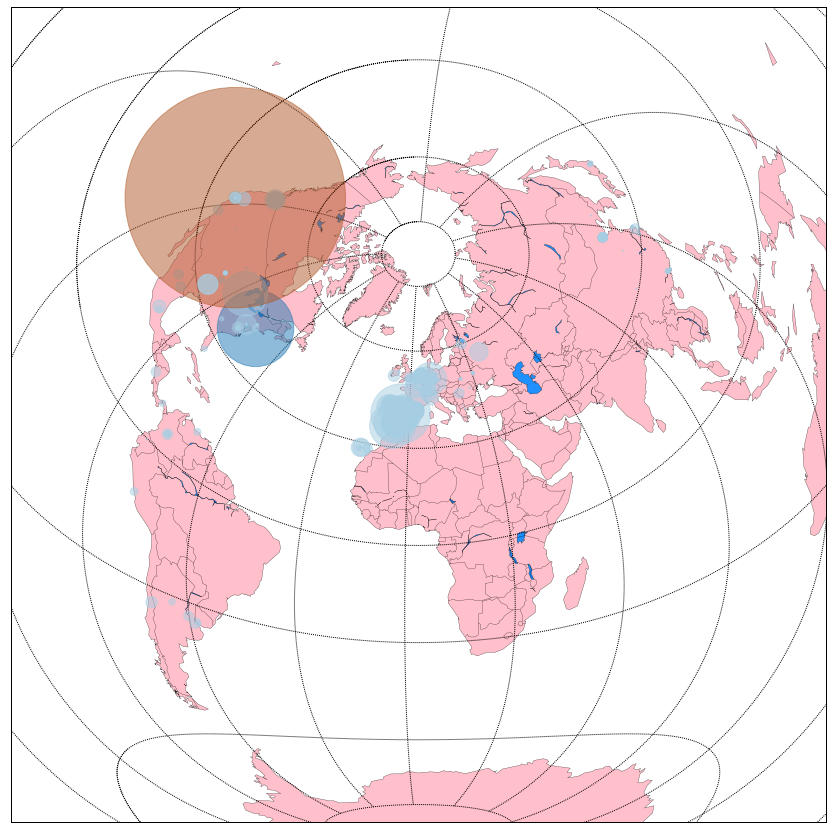

In [14]:
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
from matplotlib.pyplot import figure

width = 28000000; lon_0 = 3.7038; lat_0 = 40.4168
m = Basemap(width=width,height=width,projection='aeqd',
            lat_0=lat_0,lon_0=lon_0)

x, y = m(reg['longitude'],reg['latitude'])

figure(figsize=(15,15))
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)

m.fillcontinents(color='pink',lake_color='dodgerblue')
m.drawmapboundary(fill_color='white')
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))

m.scatter(x,y,
          s=reg['Number']*2,
          c=reg['Number']/10,
          marker='o',
          zorder=4, 
          cmap=cm.Paired,
          alpha=0.5)

Have closer look at Europe:

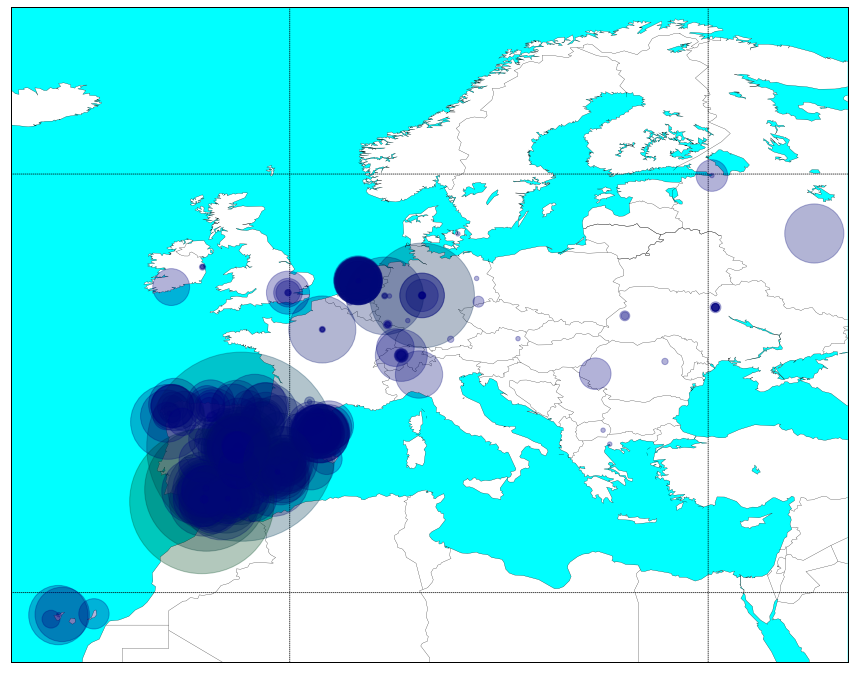

In [15]:
m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=72,\
            llcrnrlon=-20,urcrnrlon=40,resolution='l')

x, y = m(reg['longitude'],reg['latitude'])

figure(figsize=(15,15))
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
m.fillcontinents(color='white',lake_color='aqua')
m.drawmapboundary(fill_color='aqua')
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
m.scatter(x,y,
          s=reg['Number']*20,
          c=reg['Number'],
          marker='o',
          zorder=4, 
          cmap=cm.gist_ncar,
          alpha=0.3)
